In [1]:
# colab only
# !pip install tf-nightly

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

import pathlib
import pydot

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
DRIVE_FOLDER = "../food201/" # "/content/drive/My Drive/food201"

In [5]:
SUBSET_FOLDER = ""

In [6]:
TRAIN_DATA_FOLDER = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/segmented_train")
TEST_DATA_FOLDER = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/segmented_test")

TRAIN_MASK_FOLDER = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/new_masks_train")
TEST_MASK_FOLDER = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/new_masks_test")

## Settings

In [7]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

In [8]:
CLASSES = 202

## Load data

In [9]:
def load_filenames(data_dir):
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print(f"Prefetched: {image_count} images")
    test_filenames = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
    return image_count, test_filenames.shuffle(image_count, reshuffle_each_iteration=False)

In [10]:
TEST_SIZE, test_data = load_filenames(TEST_DATA_FOLDER)

Prefetched: 2439 images


In [11]:
TRAIN_SIZE, train_data = load_filenames(TRAIN_DATA_FOLDER)


Prefetched: 9654 images


## Create `image, label` tuples

In [12]:
def get_mask(image_path):
    # Produce correct path.
    mask_path = tf.strings.regex_replace(image_path, 'segmented', 'new_masks')
    mask_file = tf.strings.regex_replace(mask_path, '.jpg', '.png')

    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask)
    return mask

In [13]:
def get_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

In [14]:
def prepare_example(image_path):
    image = get_image(image_path)
    mask = get_mask(image_path)
    return image, mask

In [15]:
# Process datasets.
train_data = train_data.map(prepare_example, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
test_data = test_data.map(prepare_example, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)

## Create validation split

In [16]:
VAL_RATIO = 0.75

In [17]:
train_indices = np.random.choice(range(TRAIN_SIZE), int(VAL_RATIO * TRAIN_SIZE), replace=False)
print(f"Train size: {train_indices.shape[0]}")

Train size: 7240


In [18]:
val_indices = list(set(range(TRAIN_SIZE)) - set(train_indices))
print(f"Validation size: {len(val_indices)}")

Validation size: 2414


In [19]:
def subset_dataset(dataset, indices):
    return dataset.enumerate().filter(lambda i, t: tf.reduce_any(i == indices)).map(lambda j, u: u)

In [20]:
train_data = subset_dataset(train_data, train_indices)
val_data = subset_dataset(train_data, val_indices)

## Cache

In [21]:
# We cache before augmentations to maintain variability across epochs.
train_data = train_data.cache()

In [22]:
# Need to resize validation and test data first since we don't augment these.
def resize_example(image, mask):
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    mask = tf.image.resize(mask, [IMAGE_HEIGHT, IMAGE_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, mask

In [23]:
val_data = val_data.map(resize_example).cache()
test_data = test_data.map(resize_example).cache()

## Image augmentations

We use out of model augmentations so that we don't need to include the heavy weight `Tensorflow Ops` in our app.
Additionally this allows us to use also augmentations that change mask.

The downside is significant slowdown since we cannot cache the augmentations.

In [24]:
HSV = [0.3, 0.3, 0.3]

def random_hsv(image):
    if tf.random.uniform([]) < HSV[0]:
        image = tf.image.adjust_hue(image, tf.random.uniform([], -0.1, 0.1))
    if tf.random.uniform([]) < HSV[1]:
        image = tf.image.adjust_saturation(image, tf.random.uniform([], 0.25, 4))
    if tf.random.uniform([]) < HSV[2]:
        image = tf.image.adjust_brightness(image, tf.random.uniform([], -1, 1))
    return image

In [25]:
HFLIP_PROB = 0.5
HSV_PROB = 0.5
ROT_PROB = 0.5
SHIFT = 24

In [26]:
def image_augment(image, mask):
    # Horizontal flip.
    if tf.random.uniform([]) < HFLIP_PROB:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Color augmentations.
    if tf.random.uniform([]) < HSV_PROB:
        image = random_hsv(image)

    # Rotation cc by 90 deg.
    if tf.random.uniform([]) < ROT_PROB:
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)

    # Shifted resize to desired dimensions.
    shifted_height = tf.random.uniform([], minval=IMAGE_HEIGHT, maxval=IMAGE_HEIGHT + SHIFT, dtype=tf.int32)
    shifted_width = tf.random.uniform([], minval=IMAGE_WIDTH, maxval=IMAGE_WIDTH + SHIFT, dtype=tf.int32)

    image = tf.image.resize(image, [shifted_height, shifted_width])
    # Resize mask using nearest neighbor to avoid introducing non-existent labels.
    mask = tf.image.resize(mask, [shifted_height, shifted_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = tf.image.random_crop(image, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    mask = tf.image.random_crop(mask, [IMAGE_HEIGHT, IMAGE_WIDTH, 1])

    return image, mask

In [27]:
# Augment only training dataset.
train_data = train_data.map(image_augment)

## Batching

In [28]:
SHUFFLE_BUFFER = 500
BATCH_SIZE = 8

In [29]:
def batch_and_tune(dataset):
  dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [30]:
train_data = batch_and_tune(train_data)
val_data = batch_and_tune(val_data) # Shuffle too, so we see different pictures in callback.

## Callbacks

In [31]:
# Visualization callback to see how mask prediction progresses.
class MaskCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_mask_predictions(val_data, 3)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [32]:
def plot_mask_predictions(dataset, examples=3):
    plt.figure(figsize=(21, 7 * examples))

    for i, (image, mask) in enumerate(dataset.take(examples)):
        ax = plt.subplot(examples, 3, 3*i+1)
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.axis("off")

        ax = plt.subplot(examples, 3, 3*i+2)
        plt.imshow(mask[0].numpy().astype("uint8").squeeze(axis=2), cmap='gray', vmin=0, vmax=tf.math.reduce_max(mask[0]))
        plt.axis("off")


        pred_mask = create_mask(model.predict(image))

        ax = plt.subplot(examples, 3, 3*i+3)
        plt.imshow(pred_mask.numpy().astype("uint8").squeeze(axis=2), cmap='gray', vmin=0, vmax=tf.math.reduce_max(pred_mask))
        plt.axis("off")

    plt.show()

In [33]:
mask_callback = MaskCallback()
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1)

## Load MobileNet v3

In [34]:
# IMPORTANT: Run this just once per Jupyter kernel start since new loads increase layer numbers.
mobile_net = tf.keras.applications.MobileNetV3Large(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), alpha=1.0, minimalistic=False, include_top=False,
    weights='imagenet', input_tensor=None, pooling=None,
    dropout_rate=0.2
)

In [35]:
# U-net encoder skips.
encoder_layers = [
    're_lu_2',   # \2^1
    're_lu_6',   # \2^2
    'multiply_1',   # \2^3
    'multiply_13',  # \2^4
    'Conv_1',      # \2^5 (7x7 for 224x224)
]

encoder = [mobile_net.get_layer(l).output for l in encoder_layers]
encoder = tf.keras.Model(inputs=mobile_net.input, outputs=encoder)

In [36]:
# Don't train 'imagenet' weights.
encoder.trainable = False

## Segmentation head

In [37]:
# Regularization as per recommended defaults.
GROUP_NORM = 16
DROPOUT = 0.5
L2 = tf.keras.regularizers.L2(l2=0.0001) 

In [38]:
def upsampling_layer(x, channels, kernel=(3,3), strides=(2,2), dropout=0.5):
    """
    General Conv2DTranspose -> BN -> (Dropout) -> ReLU layer.
    """
    x = tf.keras.layers.Conv2DTranspose(channels, kernel, strides=strides, padding='same', use_bias=False, kernel_regularizer=L2)(x)
    x = tfa.layers.GroupNormalization(GROUP_NORM)(x)   
    x = tf.keras.layers.Dropout(rate=dropout)(x)
    x = tf.keras.layers.ReLU()(x)
    return x

In [39]:
def convolutional_layer(x, channels, kernel=(3,3), strides=(1,1), dropout=0.5):
    x = tf.keras.layers.Conv2D(channels, kernel, strides=strides, padding="same", use_bias=False, kernel_regularizer=L2)(x)
    x = tfa.layers.GroupNormalization(GROUP_NORM)(x)
    x = tf.keras.layers.Dropout(rate=dropout)(x)
    x = tf.keras.layers.ReLU()(x)
    return x

In [40]:
def decoder(x, channels_in, channels_out):
    x = convolutional_layer(x, channels_in // 4, 1)
    x = upsampling_layer(x, channels_in // 4, 3, dropout=DROPOUT)
    x = convolutional_layer(x, channels_in // 4, 3)
    x = convolutional_layer(x, channels_out, 1)
    return x

In [41]:
decoder_filters = [(1024, 512), (512, 256), (256, 128), (128, 64), (64, 64)]  # Number of filters as we progress down the decoder.

In [42]:
inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])

# Scale to [-1, 1] as expected by mobile net.
inputs_scaled = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)(inputs)
inputs = tf.keras.layers.Input(tensor=inputs_scaled)    # Wrapper for encoder.

# Encoding.
# Set `training` to false to keep BN in inference mode for fine tuning.
encoder_outputs = encoder(inputs, training=False)

# Last model layer output.
x = encoder_outputs[-1]
# Reverse since we go from smallest to largest.
encoder_outputs = reversed(encoder_outputs[:-1])

# Forming U-net.
for encoder_output, filters in zip(encoder_outputs, decoder_filters):
    decoder_output = decoder(x, filters[0], filters[1])
    x = tf.keras.layers.Concatenate()([decoder_output, encoder_output]) # Skip connection.
    
# Head
x = upsampling_layer(x, 32, 3, 2)
x = convolutional_layer(x, 32, 3, 2)

# Get mask prediction back to original size.
outputs = tf.keras.layers.Conv2DTranspose(CLASSES, 3, strides=2, padding='same')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')
    ]
)

In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 64), 2992512     input_3[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 4, 4, 256)    245760      model[0][4]                      
__________________________________________________________________________________________________
group_normalization (GroupNorma (None, 4, 4, 256)    512         conv2d[0][0]                     
____________________________________________________________________________________________

## Model training

In [60]:
EPOCHS = 30

In [58]:
# ============================
# !!!!!! SET NEW RUN ID !!!!!!
# ============================
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/run_10/cp-{epoch:04d}.ckpt", 
    verbose=1, 
    save_weights_only=True)

In [59]:
# Let's continue training with pretrained weights on 17 epochs.
model.load_weights("checkpoints/run_09/cp-0017.ckpt")

In [61]:
model_history = model.fit(
    train_data, 
    epochs=EPOCHS, 
    validation_data=val_data, 
    callbacks=[checkpoint_callback]
)

Epoch 1/30
905/905 [==============================] - 2132s 2s/step - loss: 2.7915 - accuracy: 0.5235 - top_5_accuracy: 0.5742 - val_loss: 2.4616 - val_accuracy: 0.5662 - val_top_5_accuracy: 0.6231

Epoch 00001: saving model to checkpoints/run_10\cp-0001.ckpt
Epoch 2/30
905/905 [==============================] - 2009s 2s/step - loss: 2.7902 - accuracy: 0.5230 - top_5_accuracy: 0.5793 - val_loss: 2.4440 - val_accuracy: 0.5659 - val_top_5_accuracy: 0.6280

Epoch 00002: saving model to checkpoints/run_10\cp-0002.ckpt
Epoch 3/30
905/905 [==============================] - 1818s 2s/step - loss: 2.7871 - accuracy: 0.5238 - top_5_accuracy: 0.5779 - val_loss: 2.4336 - val_accuracy: 0.5663 - val_top_5_accuracy: 0.6296

Epoch 00003: saving model to checkpoints/run_10\cp-0003.ckpt
Epoch 4/30
905/905 [==============================] - 1833s 2s/step - loss: 2.7825 - accuracy: 0.5227 - top_5_accuracy: 0.5797 - val_loss: 2.4310 - val_accuracy: 0.5666 - val_top_5_accuracy: 0.6341

Epoch 00004: saving m

In [74]:
# ============================
# !!!!!! SET NEW RUN ID !!!!!!
# ============================
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/run_11/cp-{epoch:04d}.ckpt", 
    verbose=1, 
    save_weights_only=True)

In [ ]:
model_history_second = model.fit(
    train_data, 
    epochs=EPOCHS + 30, 
    initial_epoch=model_history.epoch[-1],
    callbacks=[checkpoint_callback]
)

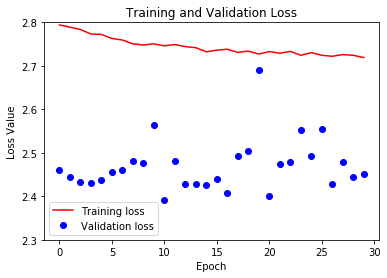

In [67]:
loss = model_history.history['loss'].copy()
val_loss = model_history.history['val_loss'].copy()

plt.figure()
plt.plot(range(EPOCHS), loss, 'r', label='Training loss')
plt.plot(range(EPOCHS), val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([2.3,2.8])
plt.legend()
plt.show()

## Results

In [50]:
# Load weights from the select epoch.
model.load_weights("checkpoints/run_06/cp-0040.ckpt")

In [48]:
model.evaluate(val_data)

230/230 [==============================] - 133s 558ms/step - loss: 2.4677 - accuracy: 0.5794 - top_5_accuracy: 0.6285


[2.4671006202697754, 0.5772510766983032, 0.6293615102767944]

In [68]:
# TODO: For some reason it does not work within the Tensorflow graph (as part of metric),
# even though only `tf.` operations are used.
def calculate_iou(y_true, y_pred):
    """
    Returns IoU of all classes.
    """
    y_true = tf.reshape(y_true, [IMAGE_HEIGHT * IMAGE_WIDTH])
    classes_true, _ = tf.unique(y_true)

    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = tf.reshape(y_pred, [IMAGE_HEIGHT * IMAGE_WIDTH])
    classes_pred, _ = tf.unique(tf.cast(y_pred, tf.uint8))

    classes, _ = tf.unique(tf.concat([classes_true, classes_pred], axis=-1))
    iou_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True)

    for i in classes:
        y_true_mask = tf.math.equal(y_true, i)
        y_pred_mask = tf.math.equal(tf.cast(y_pred, tf.uint8), i)

        intersection_mask = tf.math.logical_and(y_true_mask, y_pred_mask)
        union_mask = tf.math.logical_or(y_true_mask, y_pred_mask)

        intersection = tf.reduce_sum(tf.cast(intersection_mask, tf.float32))
        union = tf.reduce_sum(tf.cast(union_mask, tf.float32))

        #print(f"[{i}] {intersection} / {union}")
        iou = intersection / union
        iou_list = iou_list.write(iou_list.size(), iou)
    return iou_list.concat() #tf.reduce_mean(iou_list.concat())

In [71]:
test_iou_no_background = []
test_iou_top_5 = []
test_iou = []

for batch_image, batch_mask in val_data:
    batch_pred = model.predict(batch_image)
    for true_mask, pred_mask in zip(batch_mask, batch_pred):
        iou_list = calculate_iou(true_mask, pred_mask)
        try:
            iou = np.mean(iou_list)
            test_iou.append(iou)

            classes = len(iou_list)
            iou_no_background = np.mean(iou_list[1:])
            test_iou_no_background.append(iou_no_background)

            iou_top_5 = np.mean(iou_list[1:6])
            test_iou_top_5.append(iou_top_5)
        except:
            print('Only background in image.')


In [1]:
print(f"Test result without backround class: {np.mean(test_iou_no_background)}")
print(f"Test result of top 5 non background classes: {np.mean(test_iou_top_5)}")
print(f"Test result with backround class: {np.mean(test_iou)}")

In [54]:
#plot_mask_predictions(val_data, 50)

In [55]:
#plot_mask_predictions(test_data.batch(BATCH_SIZE), 50)

## Convert to `.tflite`

In [59]:
#converter = tf.lite.TFLiteConverter.from_saved_model(DRIVE_FOLDER + '/models/full_02')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Needed for the preprocessing layers.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open("./tflite_models/unet_71.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\janar\AppData\Local\Temp\tmpls5mpn_2\assets
INFO:tensorflow:Assets written to: C:\Users\janar\AppData\Local\Temp\tmpls5mpn_2\assets


21136340